In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
import numpy as np

In this file we will analyze how related genres are to each other over time by analyzing the intersection of their popular songs. Using this, we can see how genres have evolved closer together or further apart, and how genres have gained prevalence within popular music (Billboard Top 100)

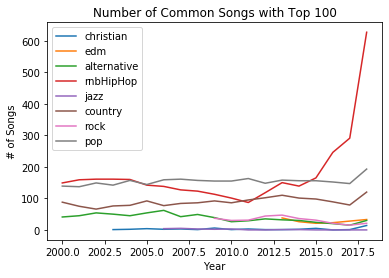

In [86]:
from functools import reduce
# This function takes 2 datasets, and returns a set of points quantifying the number of overlapping songs

weeks_per_point = 53 # 2 years

def to_set(x):
    return set(x)

def prepare(df):
    # Turn the date index into a datetime object column
    df = df.reset_index()
    df['date'] = pd.to_datetime(df['date'])
    
    # Group the songs by the date they were popular and aggregate the IDs
    grouped_dates = df.groupby('date')['id'].agg(to_set).reset_index()
    grouped_sets  = df.groupby('date')['id'].agg(to_set)

    # Aggregate the IDs into a smaller number of groups for easier comparison
    sections = []
    dates = []
    num_sections = len(grouped_sets) // weeks_per_point
    for i in range(num_sections):
        dates += [grouped_dates['date'][weeks_per_point * i]]
        if i + 1 == num_sections:
            sections += [list(grouped_sets[weeks_per_point * i:])]
        else:
            sections += [list(grouped_sets[weeks_per_point * i : weeks_per_point * (i + 1)])]
            
    # Combine the internal sets to make a list of sets
    sections = list(map(lambda a: reduce(lambda w,x: w.union(x), a), sections))
    
    # Clean the dates since we only care about the years
    dates = list(map(lambda a: a.to_pydatetime().year, dates))
    return dates, sections
    
def overlap(df1, df2):
    dates1, df1 = prepare(df1)
    dates2, df2 = prepare(df2)
    
    # Only consider overlapping data
    if len(dates1) < len(dates2):
        dates2 = dates2[-1 * len(dates1):]
        df2    =    df2[-1 * len(dates1):]
    elif len(dates2) < len(dates1):
        dates1 = dates1[-1 * len(dates2):]
        df1    =    df1[-1 * len(dates2):]

    # Count the overlap
    result = list(zip(df1, df2))
    result = list(map(lambda a: len(a[0].intersection(a[1])), result))

    return dates1, result

labels = ['christian', 'edm', 'alternative', 'rnbHipHop', 'jazz', 'country', 'rock', 'pop']
with open('../data/results/hot100.df', 'rb') as f:
    hot100 = pickle.load(f)
    
for label in labels:
    with open('../data/results/' + label + '.df', 'rb') as f:
        x, y = overlap(hot100, pickle.load(f))
        plt.plot(x,y)

plt.legend(labels)
plt.title('Number of Common Songs with Top 100')
plt.xlabel('Year')
plt.ylabel('# of Songs')
plt.show()